In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [12]:
from prism_tracker import config

root_path = config.datadrive / 'tasks' / 'latte_making'
preprocessed_dir = root_path / 'preprocessed'

In [3]:
with open(root_path / 'steps.txt') as steps_fp:
    steps = [line.strip() for line in steps_fp]

In [4]:
pickle_files = list(preprocessed_dir.glob('*.pkl'))

In [5]:
from prism_tracker.scripts.graph import build_graph

graph = build_graph(pickle_files, steps)

In [6]:
def simulate_realtime_prediction(y_all, delay=15):  # y_pred: list of predictions at each time (e.g., [[1], [1, 2], [1, 2, 3], ...])
    y_delayed = []

    for index, y_pred in enumerate(y_all):
        if len(y_pred) < delay:
            continue
        if index != len(y_all) - 1:
            y_pred = y_pred[:-delay]

        y_delayed += y_pred[len(y_delayed):]

    return y_delayed

In [13]:
import matplotlib.pyplot as plt

from prism_tracker.scripts.evaluation import perform_loo
from prism_tracker.scripts.metrics import frame_level_metrics

def evaluate(graph, pickle_files, steps, start_step_indices=None, oracle_step_indices=None):
    y_true_all, y_pred_raw_all, y_pred_viterbi_all = perform_loo(graph, pickle_files, steps, start_step_indices, oracle_step_indices)

    # emulate real-time detection
    y_true_realtime = list(map(simulate_realtime_prediction, y_true_all))
    y_pred_raw_realtime = list(map(simulate_realtime_prediction, y_pred_raw_all))
    y_pred_viterbi_realtime = list(map(simulate_realtime_prediction, y_pred_viterbi_all))

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    print('Raw prediction:')
    frame_level_metrics(y_true_realtime, y_pred_raw_realtime, num_classes=len(steps), ax=axes[0], verbose=True)
    axes[0].set_title('Raw prediction', fontsize=16)

    print('Viterbi correction:')
    frame_level_metrics(y_true_realtime, y_pred_viterbi_realtime, num_classes=len(steps), ax=axes[1], verbose=True)
    axes[1].set_title(f'Viterbi correction' + (f' with {len(oracle_step_indices)} oracles' if oracle_step_indices is not None and len(oracle_step_indices) else ''), fontsize=16)

    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
    fig.colorbar(axes[1].images[0], cax=cbar_ax)

    plt.show()

Raw prediction:
Overall accuracies: 0.5708821654489286
Overall macro recall: 0.3834483946072116
Overall macro precision: 0.4017555440657235
Overall macro F1: 0.38318808576118796
Viterbi correction:
Overall accuracies: 0.6995047320158878
Overall macro recall: 0.5234507238614767
Overall macro precision: 0.5946622470687717
Overall macro F1: 0.52696903084765


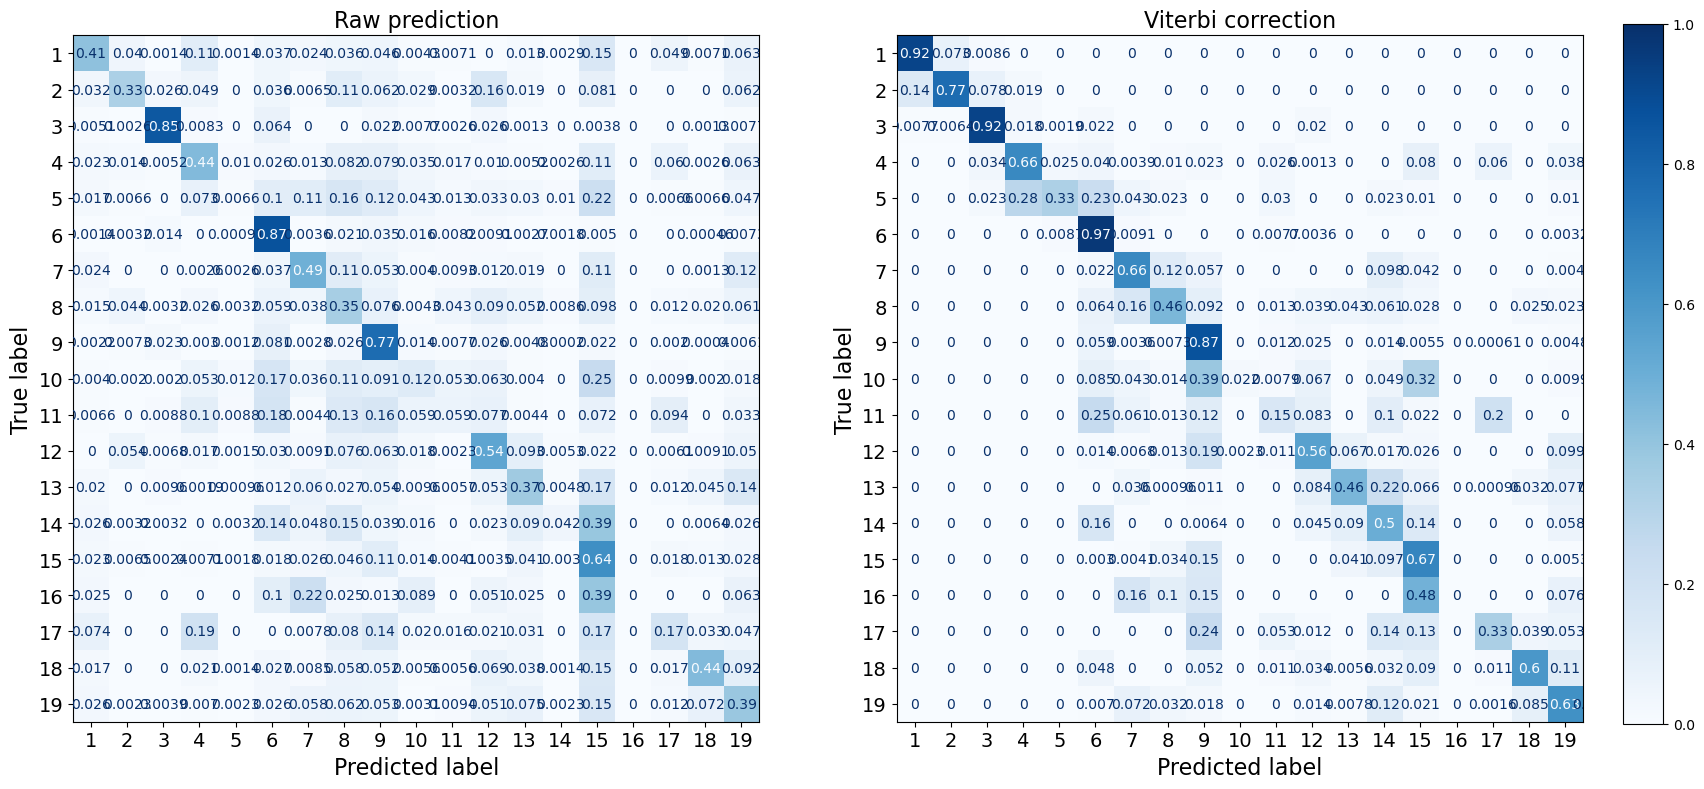

In [14]:
evaluate(graph, pickle_files, steps, start_step_indices=[graph.steps[1].index])

In [16]:
def optimization_target(graph, pickle_files, steps, start_step_indices=None, oracle_step_indices=None):
    try:
        y_true_all, _, y_pred_viterbi_all = perform_loo(graph, pickle_files, steps, start_step_indices, oracle_step_indices)
    except IndexError:
        return None, None

    y_true_realtime = list(map(simulate_realtime_prediction, y_true_all))
    y_pred_viterbi_realtime = list(map(simulate_realtime_prediction, y_pred_viterbi_all))

    return frame_level_metrics(y_true_realtime, y_pred_viterbi_realtime, num_classes=len(steps), ax=None)


def find_good_oracles(graph, pickle_files, steps, start_step_indices=None):
    accuracy, f1 = optimization_target(graph, pickle_files, steps, start_step_indices=start_step_indices)
    oracle_histories = [([], accuracy, f1)]

    for trial in range(len(steps)):
        oracle_step_indices, best_accuracy, best_f1 = oracle_histories[-1]
        best_index = None

        for oracle_step_index in range(len(steps)):
            if oracle_step_index in oracle_step_indices:
                continue

            accuracy, f1 = optimization_target(graph, pickle_files, steps, start_step_indices, oracle_step_indices + [oracle_step_index])
            if f1 is not None and f1 > best_f1:
                best_index, best_accuracy, best_f1 = oracle_step_index, accuracy, f1

        if best_index is None:
            break

        oracle_histories.append((oracle_step_indices + [best_index], best_accuracy, best_f1))
        print(f'Oracle: {oracle_histories[-1][0]} = {best_accuracy}')

    return oracle_histories

In [17]:
oracle_histories = find_good_oracles(graph, pickle_files, steps, start_step_indices=[graph.steps[1].index])

Oracle: [7] = 0.7112734761928112
Oracle: [7, 16] = 0.7226008924631001
Oracle: [7, 16, 12] = 0.7458441622125239
Oracle: [7, 16, 12, 15] = 0.7763448242043839
Oracle: [7, 16, 12, 15, 10] = 0.7973324179865641
Oracle: [7, 16, 12, 15, 10, 11] = 0.8100818908448978
Oracle: [7, 16, 12, 15, 10, 11, 14] = 0.8375913303584563
Oracle: [7, 16, 12, 15, 10, 11, 14, 2] = 0.8435737753150591
Oracle: [7, 16, 12, 15, 10, 11, 14, 2, 9] = 0.890648752022753
Oracle: [7, 16, 12, 15, 10, 11, 14, 2, 9, 5] = 0.9091354876673369
Oracle: [7, 16, 12, 15, 10, 11, 14, 2, 9, 5, 17] = 0.9200706124650615
Oracle: [7, 16, 12, 15, 10, 11, 14, 2, 9, 5, 17, 8] = 0.9300740450154464
Oracle: [7, 16, 12, 15, 10, 11, 14, 2, 9, 5, 17, 8, 19] = 0.9518462217427549
Oracle: [7, 16, 12, 15, 10, 11, 14, 2, 9, 5, 17, 8, 19, 18] = 0.9600353062325307
Oracle: [7, 16, 12, 15, 10, 11, 14, 2, 9, 5, 17, 8, 19, 18, 13] = 0.9735693620359928
Oracle: [7, 16, 12, 15, 10, 11, 14, 2, 9, 5, 17, 8, 19, 18, 13, 6] = 0.9810719364487814
Oracle: [7, 16, 12, 15,

In [10]:
oracle_histories = find_good_oracles(graph, pickle_files, steps, start_step_indices=[graph.steps[1].index])

Oracle: [7] = 0.7270141715294464
Oracle: [7, 5] = 0.7532486637571716
Oracle: [7, 5, 17] = 0.7696758691707939
Oracle: [7, 5, 17, 15] = 0.7943902319423332
Oracle: [7, 5, 17, 15, 16] = 0.7988525474427499
Oracle: [7, 5, 17, 15, 16, 19] = 0.8221938900603148
Oracle: [7, 5, 17, 15, 16, 19, 10] = 0.8477418722110528
Oracle: [7, 5, 17, 15, 16, 19, 10, 14] = 0.8759868582356691
Oracle: [7, 5, 17, 15, 16, 19, 10, 14, 13] = 0.8968273427156377
Oracle: [7, 5, 17, 15, 16, 19, 10, 14, 13, 11] = 0.9094787427058304
Oracle: [7, 5, 17, 15, 16, 19, 10, 14, 13, 11, 9] = 0.9408620605109597
Oracle: [7, 5, 17, 15, 16, 19, 10, 14, 13, 11, 9, 18] = 0.9502280194184279
Oracle: [7, 5, 17, 15, 16, 19, 10, 14, 13, 11, 9, 18, 2] = 0.9561123915068896
Oracle: [7, 5, 17, 15, 16, 19, 10, 14, 13, 11, 9, 18, 2, 6] = 0.9636149659196783
Oracle: [7, 5, 17, 15, 16, 19, 10, 14, 13, 11, 9, 18, 2, 6, 12] = 0.9701858480851272
Oracle: [7, 5, 17, 15, 16, 19, 10, 14, 13, 11, 9, 18, 2, 6, 12, 8] = 0.9758740744373069
Oracle: [7, 5, 17, 15

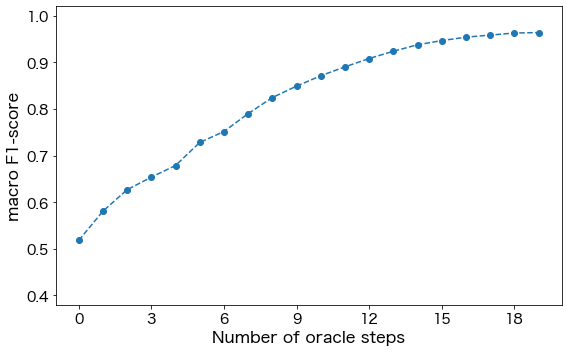

In [11]:
oracles, accuracies, f1s = zip(*oracle_histories)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(list(map(len, oracles)), f1s, linestyle='--', marker='o')

ax.set_ylim(0.38, 1.02)
ax.set_xticks(range(0, 20, 3))

ax.set_xlabel('Number of oracle steps', fontsize=16)
ax.set_ylabel('macro F1-score', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

fig.tight_layout()
fig.show()